In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from wordcloud import WordCloud
import MeCab

In [3]:
# wikipediaの日本語版から作られたコーパス
# https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/ja.text8.zip
df = pd.read_csv('../input/amazon_reviews_multilingual_JP_v1_00.tsv', sep='\t')
print(df.shape)
df.head()

(262256, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,JP,65317,R33RSUD4ZTRKT7,B000001GBJ,957145596,SONGS FROM A SECRET GARDE,Music,1,1,15,N,Y,残念ながら…,残念ながら…趣味ではありませんでした。ケルト音楽の範疇にも幅があるのですね…,2012-12-05
1,JP,65317,R2U1VB8GPZBBEH,B000YPWBQ2,904244932,鏡の中の鏡‾ペルト作品集(SACD)(Arvo Part:Spiegel im Spiegel),Music,1,4,20,N,Y,残念ながら…,残念ながら…趣味ではありませんでした。正直退屈…眠気も起きない…,2012-12-05
2,JP,65696,R1IBRCJPPGWVJW,B0002E5O9G,108978277,Les Miserables 10th Anniversary Concert,Music,5,2,3,N,Y,ドリームキャスト,素晴らしいパフォーマンス。ミュージカル映画版の物足りない歌唱とは違います。,2013-03-02
3,JP,67162,RL02CW5XLYONU,B00004SRJ5,606528497,It Takes a Nation of Millions to Hold Us Back,Music,5,6,9,N,Y,やっぱりマスト,専門的な事を言わずにお勧めレコメを書きたいのですが、文才が無いので無理でした。ヒップホップが...,2013-08-11
4,JP,67701,R2LA2SS3HU3A3L,B0093H8H8I,509738390,Intel CPU Core I3-3225 3.3GHz 3MBキャッシュ LGA1155...,PC,4,2,4,N,Y,コスパ的には十分,今までの環境（Core2 Duo E4600)に比べれば十分に快適になりました。<br />...,2013-02-10


# tokenizer作成
- 品詞を限定して、分かち書きした、単語のリストを返す

In [4]:
tagger = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
def tokenize(text, target=['名詞', '動詞']):
        # 連結リスト
        node = tagger.parseToNode(text)

        result = []
        while node:
            hinshi = node.feature.split(",")[0]
            if hinshi in target:
                if node.feature.split(",")[6]!='*':
                    result.append(node.feature.split(",")[6])
                else:
                    result.append(node.surface)  # 原形で取得しようとする場合、英字だと表示されずに「*」となることがあるため、その場合はsurfaceを取る
            node = node.next

        return result

In [5]:
# 確認
text = '私は今日パンを食べました。'
print(tagger.parse(text))

私	ワタシ	私	名詞-代名詞-一般		
は	ハ	は	助詞-係助詞		
今日	キョウ	今日	名詞-副詞可能		
パン	パン	パン	名詞-一般		
を	ヲ	を	助詞-格助詞-一般		
食べ	タベ	食べる	動詞-自立	一段	連用形
まし	マシ	ます	助動詞	特殊・マス	連用形
た	タ	た	助動詞	特殊・タ	基本形
。	。	。	記号-句点		
EOS



In [6]:
text = '私は今日パンを食べました。'
node = tagger.parseToNode(text)
while node:
    print(node.feature)
    node = node.next

BOS/EOS,*,*,*,*,*,*,*,*
名詞,代名詞,一般,*,*,*,私,ワタシ,ワタシ
助詞,係助詞,*,*,*,*,は,ハ,ワ
名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
名詞,一般,*,*,*,*,パン,パン,パン
助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
動詞,自立,*,*,一段,連用形,食べる,タベ,タベ
助動詞,*,*,*,特殊・マス,連用形,ます,マシ,マシ
助動詞,*,*,*,特殊・タ,基本形,た,タ,タ
記号,句点,*,*,*,*,。,。,。
BOS/EOS,*,*,*,*,*,*,*,*


In [7]:
tokenize(text)

['私', '今日', 'パン', '食べる']

# Word count

In [8]:
%%time
word_list = [tokenize(text, target=['名詞']) for text in df['review_body']]

CPU times: user 2min 52s, sys: 17 s, total: 3min 9s
Wall time: 4min 24s


In [9]:
word_list[0]

['残念', '趣味', 'ケルト音楽', '範疇', '幅', 'の']

In [10]:
# 各行ごとのリストのリストでなく、1つのwordリストに
word_list_all = []
for w in word_list:
    word_list_all.extend(w)

In [11]:
from collections import Counter
cnt_word = Counter(word_list_all)
cnt_word.most_common(n=10)

[('BR', 1424515),
 ('の', 272086),
 ('ã', 219771),
 ('こと', 136510),
 ('よう', 118250),
 ('映画', 111332),
 ('作品', 104207),
 ('アルバム', 73275),
 ('曲', 67552),
 ('的', 66573)]

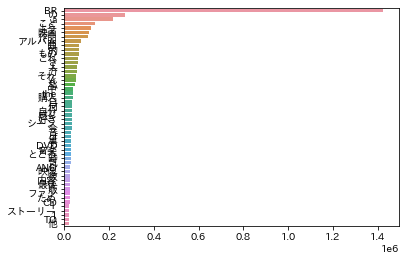

In [12]:
cnt_word_keys = []
cnt_word_values = []
for c in cnt_word.most_common(n=50):
    cnt_word_keys.append(c[0])
    cnt_word_values.append(c[1])

# plt.figure(figsize=(10, 20))
sns.barplot(x=cnt_word_values, y=cnt_word_keys)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=12)
plt.show()

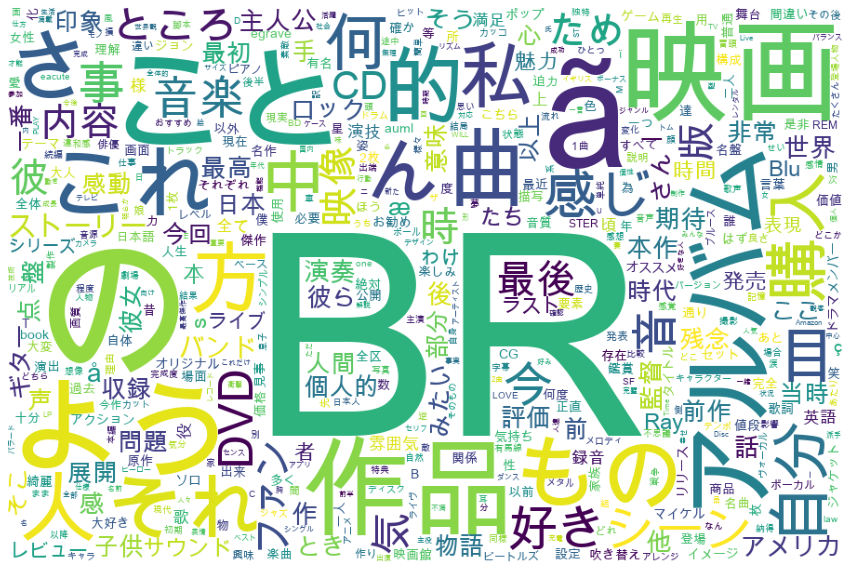

In [13]:
fpath = "/Library/Fonts/Arial Unicode.ttf"
words_wakati = ' '.join(word_list_all)

wordcloud = WordCloud(
    font_path=fpath,
    width=900, height=600,   # default width=400, height=200
    background_color="white",   # default=”black”
#     stopwords=set(stop_words),
    max_words=500,   # default=200
    min_font_size=4,   #default=4
    collocations = False   #default = True
    ).generate(words_wakati)
 
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
# plt.savefig("word_cloud.png")
plt.show()

# 前処理

### htmlタグの除去

In [14]:
from bs4 import BeautifulSoup

def clean_html(text, strip=True):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text(strip=strip)
    return text

In [15]:
# 確認
text = '\n\n\n  これはExampleです。　 \n \n '
print(clean_html(text))

これはExampleです。


### 数値の置き換え
- wordカウントの場合は、数値があまり意味がないことが多い

In [16]:
import re
def nornalize_number(text):
    text = re.sub(r'\d+', '0', text)
    return text

### アルファベットの大文字、小文字の統一
- 意味があることが多いので、しなくても良い

In [17]:
def make_lower(text):
    return text.lower()

### ストップワードの除去
- ここでは、SlothLibの日本語で定義されたストップワードを使用
    - https://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt

In [18]:
with open('../input/stopwords_slothlib.txt', 'r') as f:
    stopwords = [w.strip() for w in f]
    stopwords = set(stopwords)

In [19]:
stopwords

{'',
 'あそこ',
 'あたり',
 'あちら',
 'あっち',
 'あと',
 'あな',
 'あなた',
 'あれ',
 'いくつ',
 'いつ',
 'いま',
 'いや',
 'いろいろ',
 'うち',
 'おおまか',
 'おまえ',
 'おれ',
 'かく',
 'かたち',
 'かやの',
 'から',
 'がい',
 'がら',
 'きた',
 'くせ',
 'ここ',
 'こちら',
 'こっち',
 'こと',
 'これ',
 'これら',
 'ごっちゃ',
 'ごと',
 'ごろ',
 'さまざま',
 'さらい',
 'さん',
 'しかた',
 'しよう',
 'すか',
 'すね',
 'すべて',
 'ずつ',
 'ぜんぶ',
 'そう',
 'そこ',
 'そちら',
 'そっち',
 'そで',
 'その後',
 'それ',
 'それぞれ',
 'それなり',
 'たくさん',
 'たち',
 'たび',
 'ため',
 'だめ',
 'ちゃ',
 'ちゃん',
 'てん',
 'とおり',
 'とき',
 'ところ',
 'どこ',
 'どこか',
 'どちら',
 'どっか',
 'どっち',
 'どれ',
 'なか',
 'なかば',
 'など',
 'なに',
 'なん',
 'はじめ',
 'はず',
 'はるか',
 'ひと',
 'ひとつ',
 'ふく',
 'ぶり',
 'へん',
 'べつ',
 'ぺん',
 'ほう',
 'ほか',
 'まさ',
 'まし',
 'まとも',
 'まま',
 'みたい',
 'みつ',
 'みなさん',
 'みんな',
 'もと',
 'もの',
 'もん',
 'やつ',
 'よう',
 'よそ',
 'わけ',
 'わたし',
 'カ所',
 'カ月',
 'ハイ',
 'レ',
 'ヵ所',
 'ヵ月',
 'ヶ所',
 'ヶ月',
 '一',
 '一つ',
 '七',
 '万',
 '三',
 '上',
 '上記',
 '下',
 '下記',
 '中',
 '九',
 '事',
 '二',
 '五',
 '人',
 '今',
 '今回',
 '他',
 '以上',
 '以下',
 '以前',
 '以後',
 '以降',
 '会',
 '伸',
 '体',
 '何

In [20]:
with open('../input/stopwords_slothlib.txt', 'r') as f:
    stopwords = [w.strip() for w in f]
    stopwords = set(stopwords)

add_stopwords = {
    '*',
    'あ','い','う','え','お',
    'か','き','く','け','こ',
    'さ','し','す','せ','そ',
    'た','ち','つ','て','と',
    'な','に','ぬ','ね','の',
    'は','ひ','ふ','へ','ほ',
    'ま','み','む','め','も',
    'や','ゆ','よ',
    'わ' ,'を','ん',
    '0', '1',
    'ã',
    'å',
    'å',
    'ä',
    'ï', 
    'è',
    'é',
    'æ',
    'ç',
    'of',
    'the',
    'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
    'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
}
stopwords = stopwords | add_stopwords

def remove_stopwords(words):
    words = [w for w in words if w not in stopwords]
    return words

# 改めて、word count

In [21]:
%%time
word_list = [tokenize(nornalize_number(clean_html(text)), target=['名詞']) for text in df['review_body']]

/Users/fmasashi/.pyenv/versions/3.8.6/envs/text_japanese/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.amazon.co.jp/gp/product/B0040NOWY8/ref=cm_cr_ryp_prd_ttl_sol_3" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 5min 27s, sys: 42.1 s, total: 6min 9s
Wall time: 6min 55s


In [22]:
# 各行ごとのリストのリストでなく、1つのwordリストに
word_list_all = []
for w in word_list:
    word_list_all.extend(w)

In [23]:
word_list_all = remove_stopwords(word_list_all)

In [24]:
cnt_word = Counter(word_list_all)
cnt_word.most_common(n=10)

[('映画', 111354),
 ('作品', 105082),
 ('曲', 87436),
 ('アルバム', 74368),
 ('購入', 38091),
 ('好き', 33780),
 ('シーン', 32754),
 ('音', 31692),
 ('音楽', 29630),
 ('DVD', 29475)]

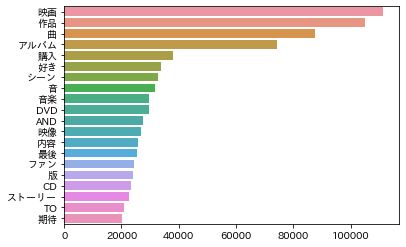

In [25]:
cnt_word_keys = []
cnt_word_values = []
for c in cnt_word.most_common(n=20):
    cnt_word_keys.append(c[0])
    cnt_word_values.append(c[1])

# plt.figure(figsize=(10, 20))
sns.barplot(x=cnt_word_values, y=cnt_word_keys)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=12)
plt.show()

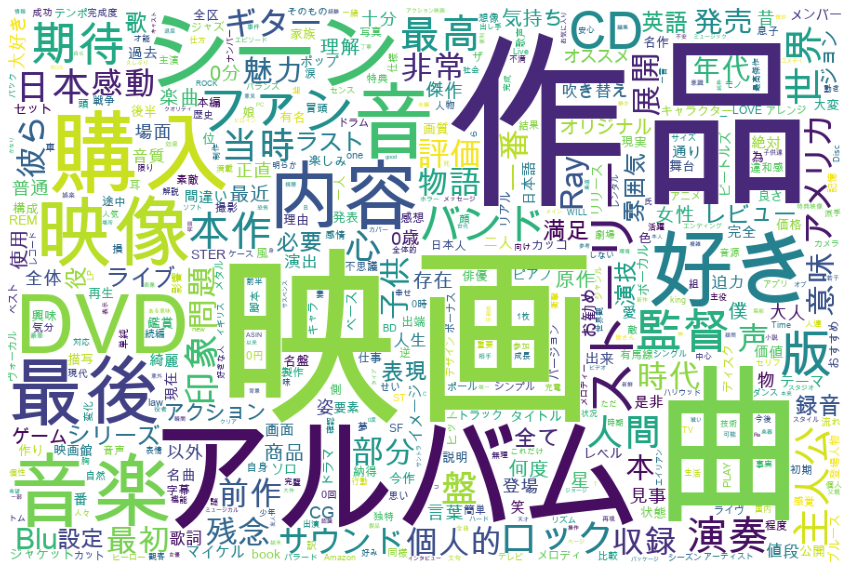

In [26]:
fpath = "/Library/Fonts/Arial Unicode.ttf"
words_wakati = ' '.join(word_list_all)

wordcloud = WordCloud(
    font_path=fpath,
    width=900, height=600,   # default width=400, height=200
    background_color="white",   # default=”black”
#     stopwords=set(stop_words),
    max_words=500,   # default=200
    min_font_size=4,   #default=4
    collocations = False   #default = True
    ).generate(words_wakati)
 
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
# plt.savefig("word_cloud.png")
plt.show()